In [2]:
from glob import glob
from datetime import datetime
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

### Q5.  What stations have seen the most usage growth/decline in the last year?

##### Load data from 2016 and format

In [10]:
files = glob('./2016_data/*.txt')
data_2016 = pd.DataFrame()
for f in files:
    data = pd.read_csv(f)
    data_2016 = data_2016.append(data)
data_2016.to_csv('data_2016.csv',index = False)

In [3]:
data_2016 = pd.read_csv('data_2016.csv')

In [4]:
data_2016['turnstile'] = data_2016['C/A']+' '+data_2016['UNIT']+' '+data_2016['SCP']
data_2016['datetime'] = data_2016['DATE']+' '+data_2016['TIME']
f = '%m/%d/%Y %H:%M:%S'
data_2016['dt'] = data_2016['datetime'].apply(lambda x: datetime.strptime(x,f))
df = data_2016.sort_values(['STATION','turnstile','dt']).reset_index()

In [13]:
#del df[['DIVISION','datetime','DESC','LINENAME','DIVISION','index']]
df.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,turnstile,dt
0,H007,R248,00-00-00,1 AV,12/26/2015,03:00:00,10536080,11482385,H007 R248 00-00-00,2015-12-26 03:00:00
1,H007,R248,00-00-00,1 AV,12/26/2015,07:00:00,10536102,11482504,H007 R248 00-00-00,2015-12-26 07:00:00
2,H007,R248,00-00-00,1 AV,12/26/2015,11:00:00,10536377,11482929,H007 R248 00-00-00,2015-12-26 11:00:00
3,H007,R248,00-00-00,1 AV,12/26/2015,15:00:00,10536886,11483458,H007 R248 00-00-00,2015-12-26 15:00:00
4,H007,R248,00-00-00,1 AV,12/26/2015,19:00:00,10537404,11484131,H007 R248 00-00-00,2015-12-26 19:00:00


In [14]:
#calculate entries/exits counts
df['entries_change'] = df.groupby(['turnstile','STATION'])['ENTRIES'].apply(lambda x: x.diff(+1))
df['exits_change'] = df.groupby(['turnstile','STATION'])['EXITS                                                               '].apply(lambda x: x.diff(+1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109587ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11423d6d8>]], dtype=object)

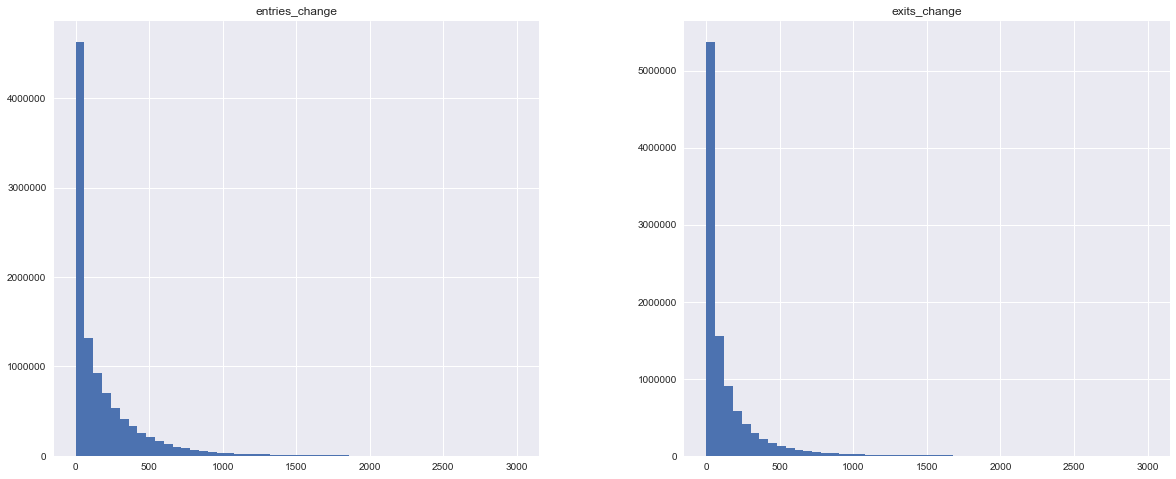

In [15]:
df[['entries_change','exits_change']].hist(bins = 50,range = (0,3000), figsize=(20, 8))

In [16]:
#remove outliers
outlier_1 = df[df['entries_change']<0].index.tolist()
outlier_2 = df[df['exits_change']<0].index.tolist()
outlier_3 = df[df['entries_change']>5000].index.tolist()
outlier_4 = df[df['exits_change']>5000].index.tolist()
outliers = outlier_1+outlier_2+outlier_3+outlier_4
df = df.fillna(0)
df.loc[outliers,['entries_change','exits_change']]=0

In [17]:
#add week and month
df['week'] = df['dt'].apply(lambda x: x.weekofyear)
df['month'] = df['dt'].apply(lambda x: x.month)

In [18]:
#select only 2016 data and calculate busyness
df=df[(df['dt']>'2016-01-01 00:00:00') & (df['dt']<='2017-01-01 00:00:00')]
df['busyness'] = df['entries_change']+df['exits_change']

In [19]:
#get weekly busyness for each station
df_weekly = df.groupby(['STATION','week']).sum().reset_index()

In [20]:
#calculate weely percentage changes for each station.
df_weekly[df_weekly['busyness'] == 0].index
df_weekly.loc[df_weekly[df_weekly['busyness'] == 0].index,'busyness'] = 1.0
df_weekly['busyness_change'] = df_weekly.groupby('STATION').pct_change()['busyness']

In [21]:
#calculate rolling changes for 4 week (~ a month) windows to smooth outliers
df_weekly['monthly_rolling_busy'] = df_weekly.groupby('STATION')['busyness_change'].apply(lambda x: x.rolling(window=4,center= True).mean())

In [24]:
df_weekly.groupby('STATION')[['busyness','busyness_change','monthly_rolling_busy']]\
.mean().sort_values(['busyness_change','monthly_rolling_busy'],ascending = False).head(15)

,busyness,busyness_change,monthly_rolling_busy
STATION,,,
PATH WTC,361905.740741,828.667901,234.171968
PENNSYLVANIA AV,29982.875000,221.800109,68.451668
ATLANTIC AV,12004.830189,159.300119,168.867797
PATH WTC 2,52208.925926,63.283652,17.876912
PATH NEW WTC,5711.166667,56.432305,36.215365
WILSON AV,49201.541667,8.336851,8.918342
SARATOGA AV,58801.314286,7.352903,8.086509
ORCHARD BEACH,933.857143,2.359332,2.390181
LACKAWANNA,91499.226415,0.637468,0.694050


##### Q5 Answer -- Most growth

Above charts are the stations showing the most growth in 2016, but if look closely, some of the stations were closed for some time but the odometer still operates and have very low readings possibly from MTA employees enter the station and when the station is reopened, the percentage change jumps very high. Take that into consideration, it seems Junius St is the one with the most growth - 15.9%. 

PATH WTC - missing data from week 27 to week 52

PENNSYLVANIA AV - Beginning on April 11, 2016 and continuing until September 19, 2016, Saratoga Avenue and Pennsylvania Avenue were closed for renovation.

ATLANTIC AV - The station was renovated in 2015–2016. Seems reopened in week 5, 2016

PATH WTC 2 - missing data from week 27 to week 52

PATH NEW WTC - temporary station

WILSON AV - closed for 6 weeks -  Wilson Ave L train station went back into service this Tuesday after six weeks of repairs and renovations

SARATOGA AV - Beginning on April 11, 2016 and continuing until September 19, 2016, Saratoga Avenue and Pennsylvania Avenue were closed for renovation.

ORCHARD BEACH - missing many weeks, also one of the least busy station

SUTTER AV-RUTLD - missing week 41-52

In [25]:
df_weekly.groupby('STATION')[['busyness','busyness_change','monthly_rolling_busy']]\
.mean().sort_values(['busyness_change','monthly_rolling_busy'],ascending = True).head(15)

,busyness,busyness_change,monthly_rolling_busy
STATION,,,
OZONE PK LEFFRT,84432.792453,-0.023856,-0.006582
88 ST,25026.660377,-0.021861,-0.004640
20 AV,52501.415094,-0.021728,-0.008773
104 ST,32855.905660,-0.020904,-0.008520
GRANT AV,73412.698113,-0.020816,-0.004292
BAY RIDGE AV,94351.094340,-0.019541,-0.011893
WALL ST,494143.509434,-0.019325,-0.003594
AVENUE N,28525.566038,-0.019276,-0.008446
BROAD CHANNEL,2397.415094,-0.019062,-0.004823


##### Q5 Answer -- Most decline
OZONE PK LEFFRT station seems to have the most decline in 2016

### Q6. What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?

In [27]:
df.groupby('DATE').sum().sort_values('busyness').head(5)

,ENTRIES,EXITS,entries_change,exits_change,week,month,busyness
DATE,,,,,,,
01/23/2016,936239496605,757905898292,1344750.0,1164727.0,81768,27256,2509477.0
01/24/2016,937425568761,751964332126,1599483.0,1276355.0,81717,27239,2875838.0
12/25/2016,980578977862,791808964863,1895774.0,1555484.0,1393779,327948,3451258.0
02/14/2016,941738946336,750302915313,2168006.0,1759799.0,163278,54426,3927805.0
11/24/2016,975856065792,788647283515,2345358.0,1910421.0,1287001,301213,4255779.0


##### Q6 Answer - least busy days
The above chart shows the 5 least busy days, when looking back into weather reports, it does make sense:

01/23/2016,01/24/2016 - Snowstorm

12/25/2016 - Christmas

02/14/2016 - record coldest Valentine's Day

In [26]:
#calculate busyness by station and dates
df_sum = df.groupby(['STATION','DATE']).sum()

##### Q6 Answer -- days when station is closed

In [179]:
print(df_sum[df_sum['busyness']<1]['busyness'])

STATION          DATE      
190 ST           07/17/2016    0.0
5 AV/53 ST       09/11/2016    0.0
88 ST            01/03/2016    0.0
                 01/31/2016    0.0
ATLANTIC AV      01/01/2016    0.0
                 01/02/2016    0.0
                 01/03/2016    0.0
                 01/04/2016    0.0
                 01/05/2016    0.0
                 01/06/2016    0.0
                 01/07/2016    0.0
                 01/08/2016    0.0
                 01/09/2016    0.0
                 01/10/2016    0.0
                 01/12/2016    0.0
                 01/13/2016    0.0
                 01/15/2016    0.0
                 01/16/2016    0.0
                 01/17/2016    0.0
                 01/18/2016    0.0
                 01/19/2016    0.0
                 01/20/2016    0.0
                 01/21/2016    0.0
                 01/22/2016    0.0
                 01/23/2016    0.0
                 01/24/2016    0.0
                 01/25/2016    0.0
                 01/26/2016

#### Q6 Answer -- days when station is not operating in full capacity (part 1)

days when station is open (with enteries and exits, but has less then 50 'busyness' counts)

This method assumes stations with less than 50 'busyness' counts are not operating in full capacity, it will miss count the least busy stations as not operatiing in full capacity, since they sometimes are not getting 50 counts even fully operates

In [28]:
df_sum[(df_sum['busyness']>=1) &(df_sum['busyness']<=50)]['busyness']

STATION          DATE      
116 ST-COLUMBIA  02/21/2016     3.0
137 ST CITY COL  02/21/2016    16.0
14TH STREET      08/07/2016    49.0
                 08/14/2016    31.0
                 08/28/2016    35.0
                 09/18/2016    10.0
                 09/25/2016    10.0
                 10/02/2016    46.0
                 10/16/2016    39.0
                 10/23/2016     7.0
                 12/04/2016    15.0
                 12/11/2016    21.0
157 ST           02/21/2016    20.0
                 06/19/2016    22.0
175 ST           06/05/2016     1.0
                 07/17/2016     6.0
                 09/25/2016     6.0
                 10/02/2016    35.0
                 10/16/2016     5.0
                 10/30/2016    32.0
                 11/13/2016    34.0
190 ST           06/05/2016    13.0
                 07/10/2016     1.0
                 08/21/2016     4.0
                 09/25/2016    11.0
                 10/02/2016    13.0
                 10/09/2016     5.0


##### Q6 Answer -- days when station is not operating in full capacity (part 2)

days when station is open (with enteries and exits, but has less then 2 standard deviation of  'busyness' counts)

This method assumes stations with less than 2 standard deviation of 'busyness' counts are not operating in full capacity, it might miss count the stations that have variance as not fully operating.

In [40]:
df_2std = df_sum.reset_index().groupby('STATION').apply(lambda x: x.mean()-2*x.std())['busyness'].reset_index()
df_2std.columns = ['STATION','threshold']
df_sum_2std = pd.merge(df_sum.reset_index(),df_2std,on='STATION')
df_low = df_sum_2std[(df_sum_2std['busyness']<df_sum_2std['threshold'])&(df_sum_2std['busyness']>0)][['STATION','DATE','busyness']]
df_low.set_index(['STATION','DATE'])

busyness
STATION       DATE                
1 AV          01/23/2016   18374.0
              01/24/2016   23652.0
              03/13/2016   23889.0
              03/20/2016   24675.0
              05/30/2016   24866.0
              07/03/2016   26399.0
              08/07/2016   26360.0
              08/14/2016   26713.0
              08/21/2016   26850.0
              09/04/2016   26481.0
              09/05/2016   24488.0
              11/24/2016   18772.0
              11/27/2016   24446.0
              12/24/2016   19444.0
              12/25/2016   13661.0
              12/26/2016   19670.0
103 ST        02/21/2016   13730.0
              04/09/2016   18500.0
              04/10/2016   15726.0
103 ST-CORONA 01/01/2016   16901.0
              01/02/2016   17924.0
              01/03/2016   14656.0
              01/10/2016   14515.0
              01/17/2016   14633.0
              01/23/2016   10662.0
              01/24/2016   11772.0
              02/14/2016   13273.0
              02/21/2016   16530.0
              02/28/2016   16029.0
              03/13/2016   11805.0
...                            ...
YORK ST       02/13/2016    7049.0
              02/14/2016    5144.0
              02/21/2016    6939.0
              03/27/2016    7835.0
              05/01/2016    7610.0
              05/28/2016    6783.0
              05/29/2016    6256.0
              05/30/2016    4515.0
              09/05/2016    7766.0
              11/06/2016    8113.0
              11/20/2016    7261.0
              11/24/2016    5418.0
              11/25/2016    8084.0
              11/27/2016    7049.0
              12/04/2016    7970.0
              12/11/2016    7612.0
              12/17/2016    8197.0
              12/18/2016    7051.0
              12/24/2016    5278.0
              12/25/2016    6383.0
              12/26/2016    5638.0
ZEREGA AV     01/24/2016    1046.0
              04/23/2016     444.0
              04/24/2016       4.0
              04/30/2016     406.0
              05/01/2016       3.0
              05/07/2016     453.0
              05/08/2016       2.0
              05/14/2016     428.0
              05/15/2016       1.0

[3562 rows x 1 columns]